# Simple Rotations of Surface Expansion
This example show how a rotation can be applied to an expansion.
We apply the rotation to a spherical surface expansion, but the same technique can be used for any type of spherical expansion.

In [1]:
import numpy as np
import shetar
import plotly.graph_objects as go

In [2]:
def show_axes(x, y, z, **kwargs):
    return go.Scatter3d(
        x=[0, x[0], 0, y[0], 0, z[0]],
        y=[0, x[1], 0, y[1], 0, z[1]],
        z=[0, x[2], 0, y[2], 0, z[2]],
        hovertext=['', 'x', '', 'y', '', 'z'],
        **kwargs
    )


def show_point(x, y, z, **kwargs):
    return go.Scatter3d(x=[0, x], y=[0, y], z=[0, z], **kwargs)

surf_layout = dict(showscale=False, colorscale='Spectral', cmid=0)
fig_layout = {
    'showlegend': False,
    'scene': {
        'xaxis': {'range': (-1.1, 1.1)},
        'yaxis': {'range': (-1.1, 1.1)},
        'zaxis': {'range': (-1.1, 1.1)},
        'aspectratio': {'x': 1, 'y': 1, 'z': 1},
        'camera': {'eye': {'x': 1, 'y': 1, 'z': 0.8}},
    }
}

We define the rotation using three rotation angles, β, α, and μ.
The field will be rotated first around the z-axis with μ, then around the y-axis by β, and finally by α around the z-axis again.

In [3]:
beta, alpha, mu = np.deg2rad([30, -45, 60])
order = 12

expansion = shetar.expansions.SphericalSurfaceExpansion(order)
beam_a = shetar.bases.SphericalHarmonics(order, colatitude=np.deg2rad(30), azimuth=np.deg2rad(30))
beam_b = shetar.bases.SphericalHarmonics(order, colatitude=np.deg2rad(60), azimuth=np.deg2rad(45))
for n in range(order+1):
    for m in range(-n, n+1):
        expansion[n, m] = beam_a[n, m].conj() - beam_b[n, m].conj()

coordinate_rotation = shetar.coordinates.Rotation(colatitude=beta, azimuth=alpha, secondary_azimuth=mu)
first_step = expansion.rotate(colatitude=0, azimuth=0, secondary_azimuth=mu)
second_step = expansion.rotate(colatitude=beta, azimuth=0, secondary_azimuth=mu)
rotated_expansion = expansion.rotate(colatitude=beta, azimuth=alpha, secondary_azimuth=mu)

We define two meshes of spherical surfaces. The first mesh is in the original coordinate system.
The second mesh will be used to show how the rotation can be interpreted as a reexpansion.
Note how the rotation matrix $Q$ is used to transform coordinates between the two systems.
As a first step, we can note that the original expansion evaluated at the original coordinates give the same values as the rotated expansion evaluated at the corresponding rotared coordinates.

In [4]:
old_x = np.array([1, 0, 0])
old_y = np.array([0, 1, 0])
old_z = np.array([0, 0, 1])
# The coordinates of the old base in the new base
new_x = coordinate_rotation.apply(old_x).xyz
new_y = coordinate_rotation.apply(old_y).xyz
new_z = coordinate_rotation.apply(old_z).xyz
# The coordinates of the new base in the new new base
new_xi = np.array([1, 0, 0])
new_eta = np.array([0, 1, 0])
new_zeta = np.array([0, 0, 1])
# The coordinates of the new base in the old base
old_xi = coordinate_rotation.apply(new_xi, inverse=True).xyz
old_eta = coordinate_rotation.apply(new_eta, inverse=True).xyz
old_zeta = coordinate_rotation.apply(new_zeta, inverse=True).xyz

old_xyz = show_axes(old_x, old_y, old_z, name='Old axes', line=dict(color='blue'))
old_xietazeta = show_axes(old_xi, old_eta, old_zeta, name='New axes', line=dict(color='red'))
new_xyz = show_axes(new_x, new_y, new_z, name='Old axes', line=dict(color='blue'))
new_xietazeta = show_axes(new_xi, new_eta, new_zeta, name='New axes', line=dict(color='red'))

res = 5
old_theta = np.linspace(0, np.pi, 180 // res + 1)
old_phi = np.linspace(0, 2 * np.pi, 360 // res + 1)
old_mesh = shetar.coordinates.SpatialCoordinate.parse_args(radius=0.8, colatitude=old_theta, azimuth=old_phi, automesh=True)
new_mesh = old_mesh.rotate(colatitude=beta, azimuth=alpha, secondary_azimuth=mu)
old_x_mesh, old_y_mesh, old_z_mesh = old_mesh.xyz
new_x_mesh, new_y_mesh, new_z_mesh = new_mesh.xyz
print(np.allclose(expansion.evaluate(old_mesh), rotated_expansion.evaluate(new_mesh)))

True


### Original field
The expansion is that of two order limited point sources on the sphere.
Note the orientation of the two maxima in relateion to the original coordinate axes in blue, and the rotated axes in red.

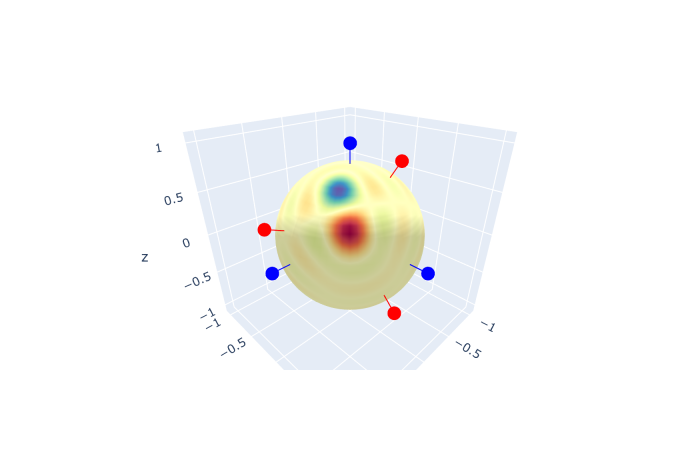

In [5]:
go.Figure([
    go.Surface(x=old_x_mesh, y=old_y_mesh, z=old_z_mesh, surfacecolor=expansion.evaluate(old_mesh).real, **surf_layout),
    old_xyz, old_xietazeta
], fig_layout).show('svg')

### First rotation
The field after rotating by μ around the z-axis.

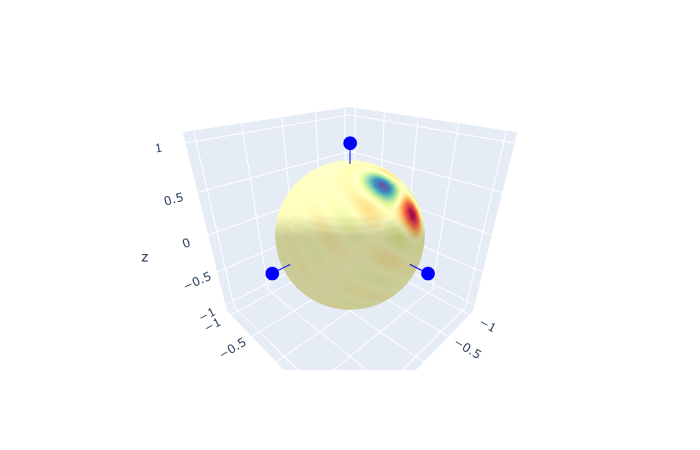

In [6]:
go.Figure([
    go.Surface(x=old_x_mesh, y=old_y_mesh, z=old_z_mesh, surfacecolor=first_step.evaluate(old_mesh).real, **surf_layout),
    old_xyz
], fig_layout).show('svg')

### Second rotation
The field after also rotating with β around the y-axis.

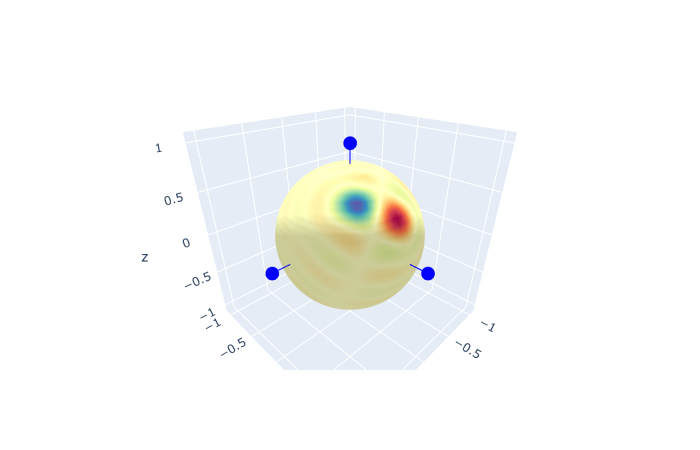

In [7]:
go.Figure([
    go.Surface(x=old_x_mesh, y=old_y_mesh, z=old_z_mesh, surfacecolor=second_step.evaluate(old_mesh).real, **surf_layout),
    old_xyz
], fig_layout).show('svg')

### Final rotated field
This is the field after rotating around the z-axis again, by α.

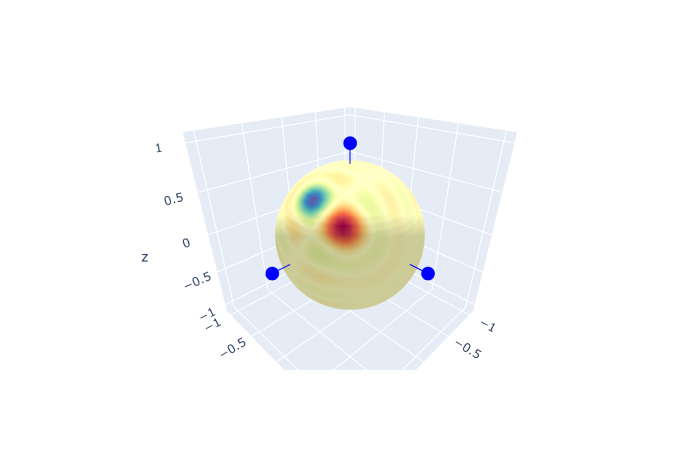

In [8]:
go.Figure([
    go.Surface(x=old_x_mesh, y=old_y_mesh, z=old_z_mesh, surfacecolor=rotated_expansion.evaluate(old_mesh).real, **surf_layout),
    old_xyz
], fig_layout).show('svg')

### Reexpansion
If we instead evaluate the rotated expansion in the rotared coordinates, we see a similar result. Note how the field is oriented compared to the original coordinate axes and the new coordinate axes both in this case and in the original unrotated case.
We see that this rotation can be interpreted as reexpanding the field in the rotated coordinate system.

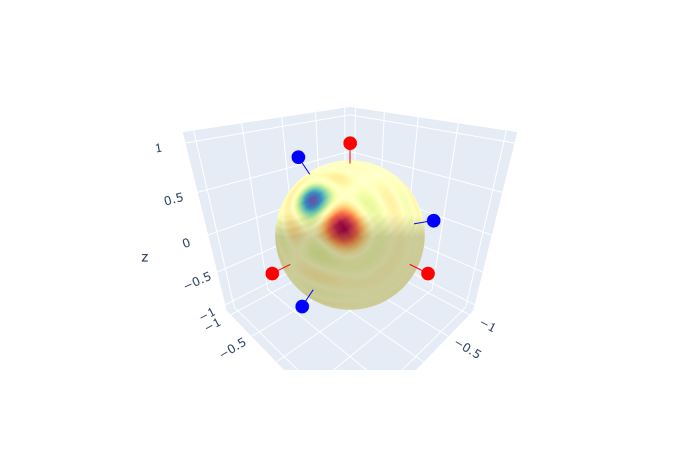

In [9]:
go.Figure([
    go.Surface(x=new_x_mesh, y=new_y_mesh, z=new_z_mesh, surfacecolor=rotated_expansion.evaluate(new_mesh).real, **surf_layout),
    new_xyz, new_xietazeta
], fig_layout).show('svg')

### Reevaluated expansion
If we evaluate the original expansion in the new coordinates, we again see the original field.
However, it is oriented with respect to the new coordinate axes instead of the old coordinate axes.

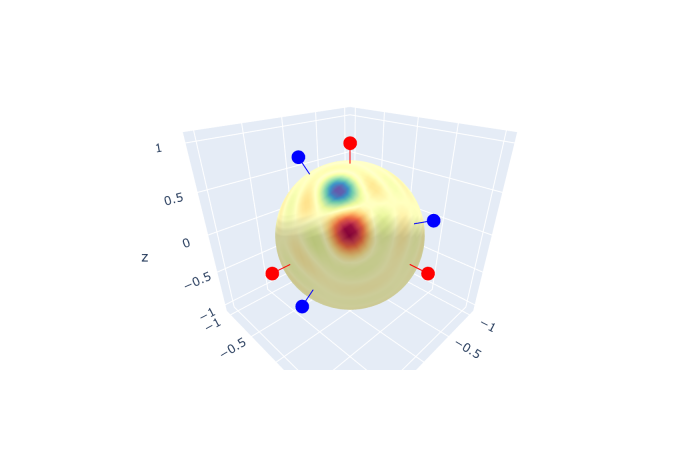

In [10]:
go.Figure([
    go.Surface(x=new_x_mesh, y=new_y_mesh, z=new_z_mesh, surfacecolor=expansion.evaluate(new_mesh).real, **surf_layout),
    new_xyz, new_xietazeta
], fig_layout).show('svg')